In [850]:
#Declarar librerias 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  StandardScaler, FunctionTransformer, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,ConfusionMatrixDisplay

In [851]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
ytest   =pd.read_csv('gender_submission.csv')

In [852]:
def DataPorcesing(df):
        df.drop(columns=['Ticket','Cabin'],inplace=True)
        df.set_index('PassengerId',inplace=True)
        df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.')
        df.drop(columns='Name',inplace=True)
        df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                        'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                        'Jonkheer', 'Dona'], 'Rare')

        # Unificar "Mlle" y "Ms" como "Miss"
        df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')

        # Unificar "Mme" como "Mrs"
        df['Title'] = df['Title'].replace('Mme', 'Mrs')
        df['Age'].fillna(df['Age'].median(), inplace=True)

        # Llenar valores faltantes en 'Embarked' con el más frecuente
        df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

        # Convertir 'Sex' a valores numéricos (0 para male, 1 para female)
        df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
        df['FamilySize'] = df['SibSp'] + df['Parch'] + 1  # Tamaño de familia
        df['IsAlone'] = (df['FamilySize'] == 1).astype(int)  # Si viaja solo
        df['FarePerPerson'] = df['Fare'] / df['FamilySize']  # Tarifa por persona
        df['Pclass*Fare'] = df['Pclass'] * df['Fare']  # Interacción Pclass * Fare
        return df
    

In [853]:
df =DataPorcesing(pd.read_csv('train.csv')) 

C:\Users\Oscar\AppData\Local\Temp\ipykernel_6280\2177550342.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
C:\Users\Oscar\AppData\Local\Temp\ipykernel_6280\2177550342.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

In [854]:

X = df.drop(columns='Survived')
y = df['Survived']

# Separar datos en entrenamiento y prueba
X_train, Xvt, y_train, yvt = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, Xval, y_test, yval = train_test_split(Xvt, yvt, test_size=0.5, random_state=42)


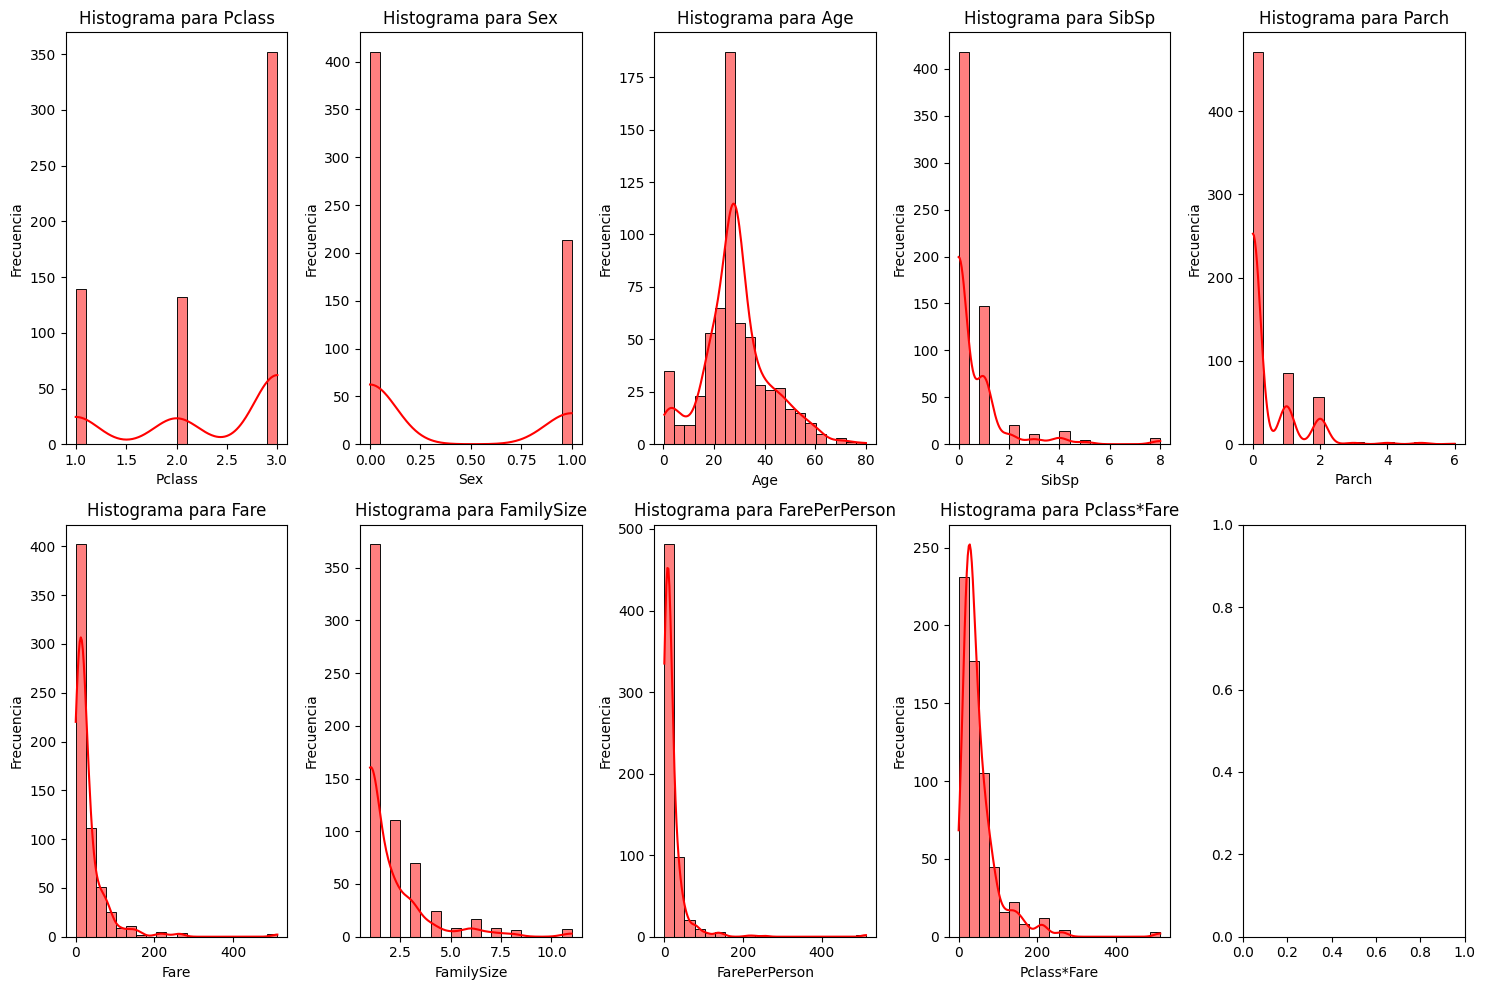

In [855]:
dfnum = X_train.select_dtypes(include=['float64', 'int64'])

fig, axes = plt.subplots(2,5, figsize=(15, 10))
axes = axes.flatten()
for i, columna in enumerate(dfnum.columns):
    sns.histplot(dfnum[columna], bins=20, color = 'red', ax=axes[i], kde=True)
    axes[i].set_title(f'Histograma para {columna}')
    axes[i].set_xlabel(columna)
    axes[i].set_ylabel('Frecuencia')
plt.tight_layout()
plt.show()

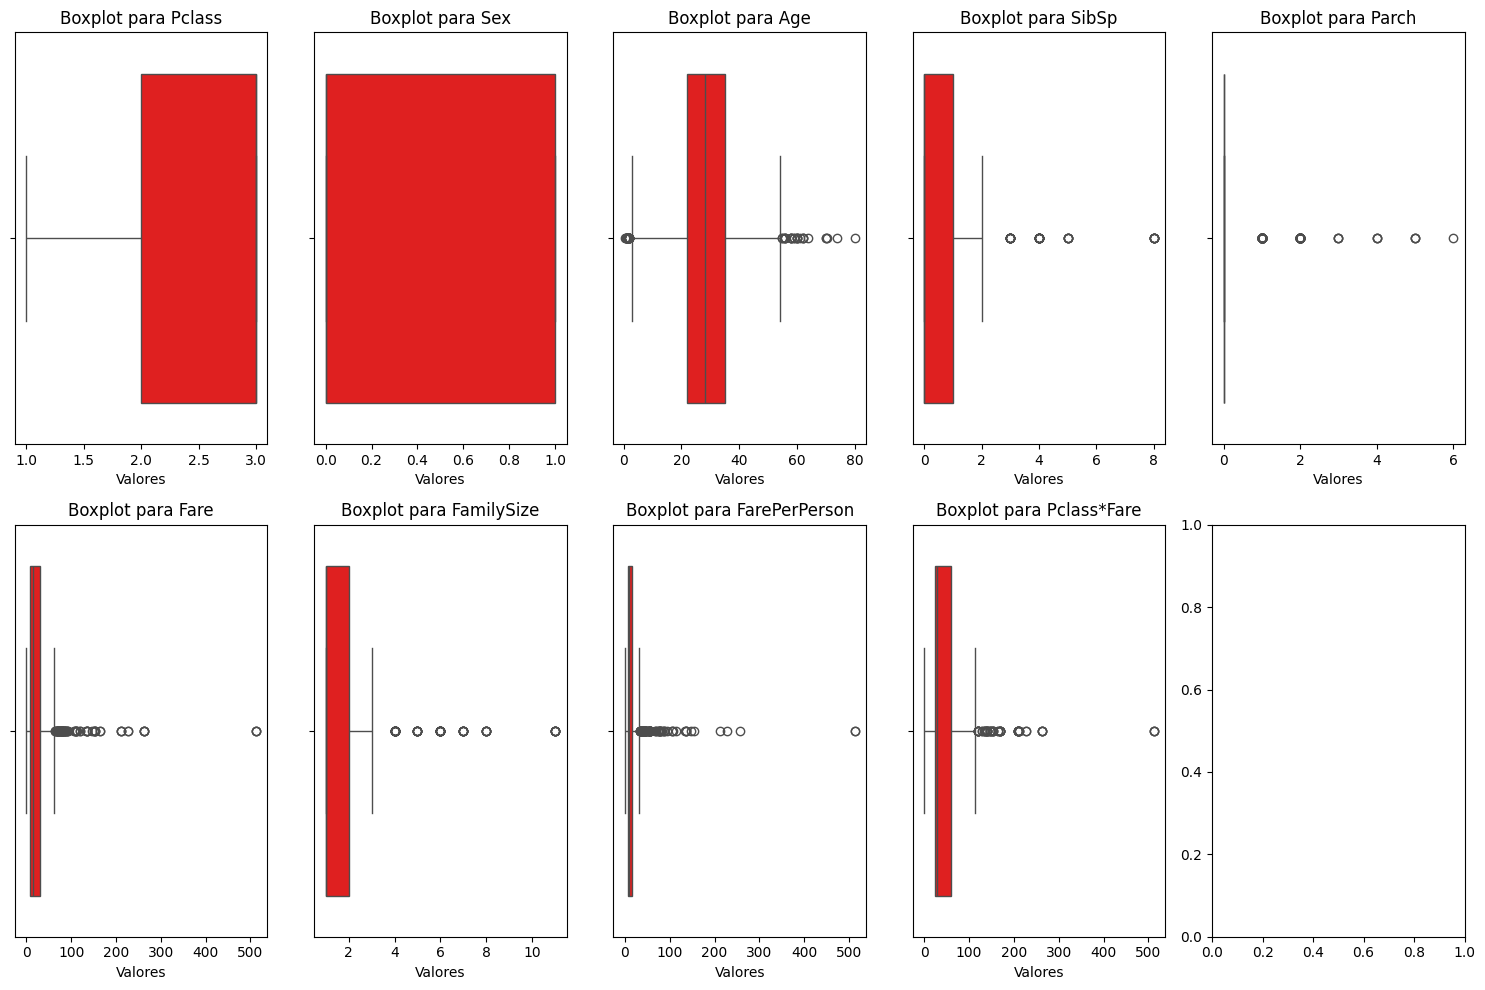

In [856]:
fig, axes = plt.subplots(2, 5, figsize=(15, 10))
axes = axes.flatten()

for i, columna in enumerate(dfnum.columns):
    sns.boxplot(data=dfnum, x=columna, ax=axes[i], color='red')
    axes[i].set_title(f'Boxplot para {columna}')
    axes[i].set_xlabel('Valores')

plt.tight_layout()
plt.show()

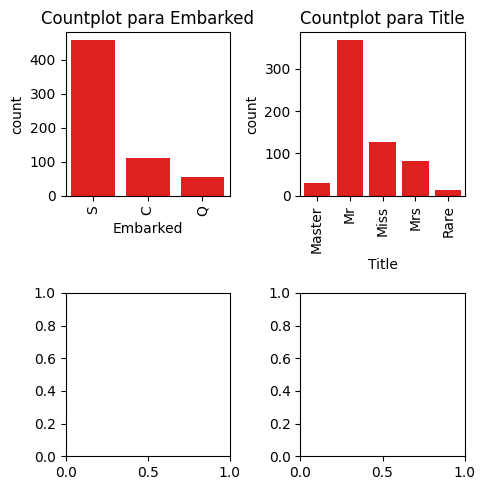

In [857]:
dfobj = X_train.select_dtypes(include = 'object')
fig, axes = plt.subplots(2,2 , figsize=(5, 5))
axes = axes.flatten()
for i, columna in enumerate(dfobj.columns):
    sns.countplot(data=dfobj, x=columna, ax=axes[i], color='red')
    axes[i].set_title(f'Countplot para {columna}')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


In [858]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone,FarePerPerson,Pclass*Fare
PassengerId,,,,,,,,,,,,
446,1,0,4.0,0,2,81.8583,S,Master,3,0,27.286100,81.8583
651,3,0,28.0,0,0,7.8958,S,Mr,1,1,7.895800,23.6874
173,3,1,1.0,1,1,11.1333,S,Miss,3,0,3.711100,33.3999
451,2,0,36.0,1,2,27.7500,S,Mr,4,0,6.937500,55.5000
315,2,0,43.0,1,1,26.2500,S,Mr,3,0,8.750000,52.5000
...,...,...,...,...,...,...,...,...,...,...,...,...
107,3,1,21.0,0,0,7.6500,S,Miss,1,1,7.650000,22.9500
271,1,0,28.0,0,0,31.0000,S,Mr,1,1,31.000000,31.0000
861,3,0,41.0,2,0,14.1083,S,Mr,3,0,4.702767,42.3249


In [873]:

# NUMÉRICAS:
numericas_pipeline = Pipeline(steps=[ ('imputer', SimpleImputer(strategy='median')),
                                      ('log_transform', FunctionTransformer(np.log1p, validate=True)),
                                      ('scaler', StandardScaler())
                                    ]
                              )


numericas_pipeline_nombres = ['Fare','Age','FarePerPerson','Pclass*Fare']

# ORDINALES:
catOrd_pipeline = Pipeline( steps=[
                                   ('imputer', SimpleImputer(strategy='most_frequent')),
                                   ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
                                  ]
                          )
catOrd_pipeline_nombres = ['Pclass','SibSp','Parch']

# BINARIAS:
catBin_pipeline = Pipeline(steps=[
                                  ('imputer', SimpleImputer(strategy='most_frequent')),
                                  ('onehot', OneHotEncoder(handle_unknown='ignore',sparse_output=False, drop='first')) ])
catBin_pipeline_nombres = ['Sex']

# NOMINALES:
catNom_pipeline = Pipeline( steps=[
                                    ('imputer', SimpleImputer(strategy='most_frequent')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse_output=False, drop='first'))
                                  ]
                          )
catNom_pipeline_nombres = ['Embarked','Title']



columnasTransformer = ColumnTransformer( transformers = [('numerica', numericas_pipeline, numericas_pipeline_nombres),
                                                         ('ordinal',catOrd_pipeline,catOrd_pipeline_nombres),
                                                         ('binaria',catBin_pipeline,catBin_pipeline_nombres),
                                                         ('Nominal',catNom_pipeline,catNom_pipeline_nombres)],
                                        remainder='passthrough' )


In [874]:

model = RandomForestClassifier(
    n_estimators = 250,  # Número de árboles en el bosque
    max_depth= 5,  # Profundidad máxima de los árboles
    min_samples_split = 20,  # Mínimo de muestras para dividir un nodo
    min_samples_leaf = 10 ,  # Mínimo de muestras en cada hoja
    max_features = 'sqrt',
    random_state=1
)
modelR = Pipeline(steps=[('preprocessing', columnasTransformer),('model', model)])
#XtestT = columnasTransformer.fit_transform(X_test)
modelR.fit(X_train, y_train)
y_pred = modelR.predict(Xval)
y_pred_tes = modelR.predict(X_test)
print("Accuracy_val:", accuracy_score(yval, y_pred))
print("Accuracy_test:", accuracy_score(y_test, y_pred_tes))



Accuracy_val: 0.8134328358208955
Accuracy_test: 0.8432835820895522


In [875]:
df_k = DataPorcesing(pd.read_csv('test.csv'))
ypreRd =  modelR.predict(df_k)

C:\Users\Oscar\AppData\Local\Temp\ipykernel_6280\2177550342.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
C:\Users\Oscar\AppData\Local\Temp\ipykernel_6280\2177550342.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

In [876]:
output = pd.DataFrame({'PassengerId': pd.read_csv('test.csv')['PassengerId'], 'Survived': ypreRd})
output.to_csv('submission_RF.csv', index=False)
print("Archivo 'submission_xgb.csv' guardado exitosamente.")

Archivo 'submission_xgb.csv' guardado exitosamente.


In [870]:
from sklearn.metrics import classification_report

print(classification_report(yval, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.90      0.86        87
           1       0.78      0.66      0.71        47

    accuracy                           0.81       134
   macro avg       0.80      0.78      0.79       134
weighted avg       0.81      0.81      0.81       134



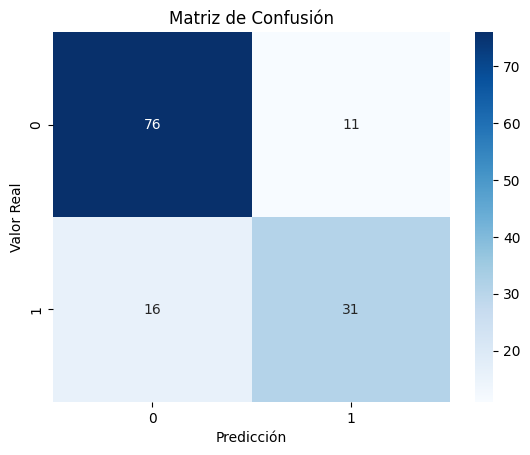

In [862]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(yval, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión")
plt.show()


In [863]:
from xgboost import XGBClassifier

xgb = XGBClassifier(colsample_bytree= 0.8, gamma= 0.3,learning_rate= 0.005, max_depth= 5, n_estimators= 250, subsample= 0.8,random_state=1)
modelxg = Pipeline(steps=[('preprocessing', columnasTransformer),('model', xgb)])
#XtestT = columnasTransformer.fit_transform(X_test)
modelxg.fit(X_train, y_train)
y_pred = modelR.predict(Xval)
y_pred_tes = modelR.predict(X_test)
print("Accuracy_val:", accuracy_score(yval, y_pred))
print("Accuracy_test:", accuracy_score(y_test, y_pred_tes))


Accuracy_val: 0.7985074626865671
Accuracy_test: 0.8507462686567164


In [864]:
df_k = DataPorcesing(pd.read_csv('test.csv'))
df_k

C:\Users\Oscar\AppData\Local\Temp\ipykernel_6280\2177550342.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
C:\Users\Oscar\AppData\Local\Temp\ipykernel_6280\2177550342.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone,FarePerPerson,Pclass*Fare
PassengerId,,,,,,,,,,,,
892,3,0,34.5,0,0,7.8292,Q,Mr,1,1,7.829200,23.4876
893,3,1,47.0,1,0,7.0000,S,Mrs,2,0,3.500000,21.0000
894,2,0,62.0,0,0,9.6875,Q,Mr,1,1,9.687500,19.3750
895,3,0,27.0,0,0,8.6625,S,Mr,1,1,8.662500,25.9875
896,3,1,22.0,1,1,12.2875,S,Mrs,3,0,4.095833,36.8625
...,...,...,...,...,...,...,...,...,...,...,...,...
1305,3,0,27.0,0,0,8.0500,S,Mr,1,1,8.050000,24.1500
1306,1,1,39.0,0,0,108.9000,C,Rare,1,1,108.900000,108.9000
1307,3,0,38.5,0,0,7.2500,S,Mr,1,1,7.250000,21.7500


In [866]:
output = pd.DataFrame({'PassengerId': pd.read_csv('test.csv')['PassengerId'], 'Survived': y_test})
output.to_csv('submission_xgb.csv', index=False)
print("Archivo 'submission_xgb.csv' guardado exitosamente.")


Archivo 'submission_xgb.csv' guardado exitosamente.
